#**Линейные модели, SVM и деревья решений**

**Цель лабораторной работы**\
Изучение линейных моделей, SVM и деревьев решений.

**Задание**
1.  Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2.  В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.  С использованием метода train_test_split разделите выборку на обучающую и тестовую.
 -  Обучите следующие модели:
 -  одну из линейных моделей;
SVM;
 -  дерево решений.
4.  Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

##**Решение**

###**Импорт библиотек и загрузка данных**

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Image
from io import StringIO 
from typing import Tuple, Dict
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree , export_graphviz
%matplotlib inline 
sns.set(style="ticks")

In [23]:
# загрузка данных
uploaded = files.upload()

Saving pulsar_stars.csv to pulsar_stars.csv


In [25]:
data = pd.read_csv('pulsar_stars.csv', sep=',')

###**Характеристики датасета**

В лабораторной работе используется датасет Pulsar Stars. Датасет содержит характеристики звезды и ее принадлежность к пульсарам или нет.\
**В датасете представлены следующие признаки:**
-  Mean of the integrated profile - среднее значение интегрированного профиля
-  Standard deviation of the integrated profile - стандартное отклонение интегрированного профиля
-  Excess kurtosis of the integrated profile - чрезмерный эксцесс интегрированного профиля
-  Skewness of the integrated profile - перекос интегрированного профиля
-  Mean of the DM-SNR curve - среднее значение кривой DM-SNR
-  Standard deviation of the DM-SNR curve - стандартное отклонение кривой DM-SNR
-  Excess kurtosis of the DM-SNR curve - избыточный эксцесс кривой DM-SNR
-  Skewness of the DM-SNR curve - асимметрия кривой DM-SNR
-  target_class - 0 (не является пульсаром), 1 (является пульсаром)

In [26]:
# размер датасета
data.shape

(17898, 9)

In [27]:
# типы колонок
data.dtypes

 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                       int64
dtype: object

In [28]:
# первые 5 строк
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [29]:
# статистические характеристики признаков
data.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [30]:
# Количество пропусков в данных
data.isna().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [31]:
# Количество уникальных значений для каждого признака
data.nunique()

 Mean of the integrated profile                   8626
 Standard deviation of the integrated profile    17862
 Excess kurtosis of the integrated profile       17897
 Skewness of the integrated profile              17898
 Mean of the DM-SNR curve                         9000
 Standard deviation of the DM-SNR curve          17894
 Excess kurtosis of the DM-SNR curve             17895
 Skewness of the DM-SNR curve                    17895
target_class                                         2
dtype: int64

###**Разделение выборки на обучающую и тестовую**

In [32]:
# разделим данные на целевой столбец и признаки
X = data.drop("target_class", axis=1)
Y = data["target_class"]

In [33]:
# с использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((13423, 8), (4475, 8), (13423,), (4475,))

###**Линейная модель**

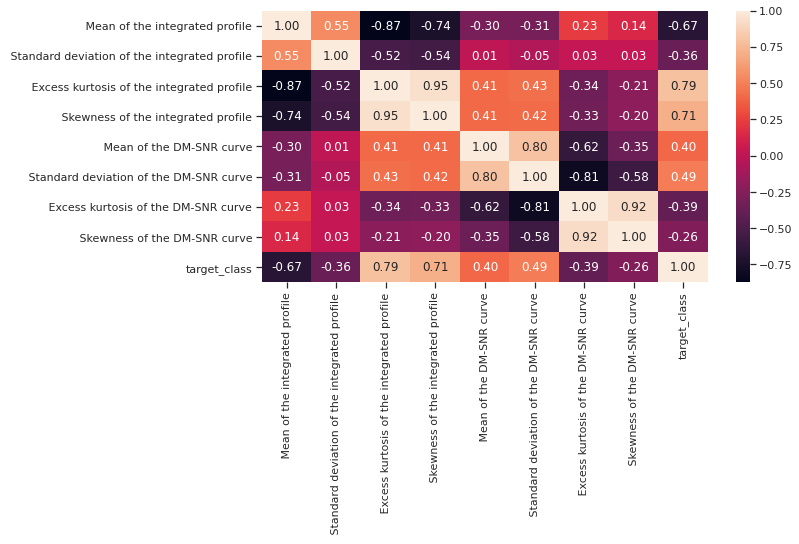

In [34]:
# построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

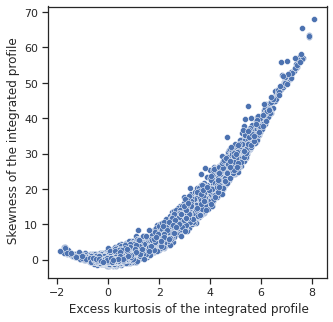

In [42]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=' Excess kurtosis of the integrated profile', y=' Skewness of the integrated profile', data=data)

In [45]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [46]:
x_array = data[' Excess kurtosis of the integrated profile'].values
y_array = data[' Skewness of the integrated profile'].values

In [47]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-0.8493834635342365, 5.482102483932346)

In [48]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [49]:
y_array_regr = y_regr(x_array, b0, b1)

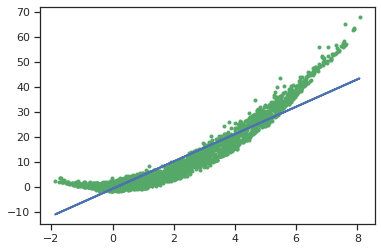

In [50]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

In [51]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [52]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = -0.8493834635342365 - (теоретический), 0.03448999261498756 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 0.13918310376478424 - (градиентный спуск)
MSE = 35.104804413419025


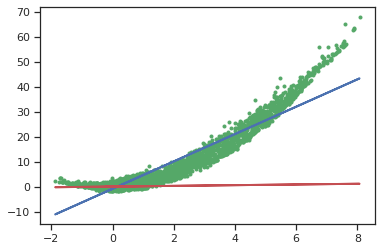

In [53]:
# Примеры использования градиентного спуска
show_gradient_descent(10, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -0.1046956764421704 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 4.8016950489981 - (градиентный спуск)
MSE = 0.700140861729278


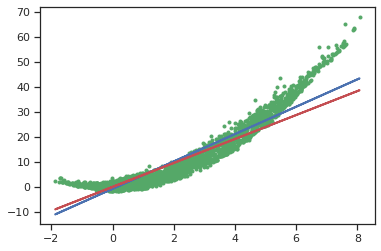

In [54]:
show_gradient_descent(1000, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -0.8493787037369952 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 5.482099192076996 - (градиентный спуск)
MSE = 2.2423416471452288e-11


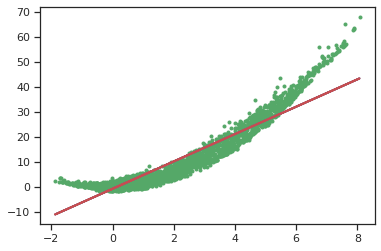

In [55]:
show_gradient_descent(10000, 0, 0)

b0 = -0.8493834635342365 - (теоретический), -1.972729515823501 - (градиентный спуск)
b1 = 5.482102483932346 - (теоретический), 5.023704112532512 - (градиентный спуск)
MSE = 2.039915190146421


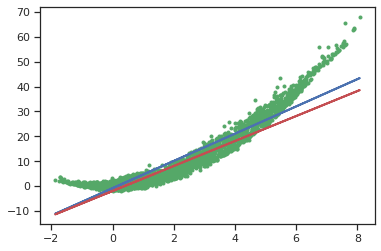

In [56]:
show_gradient_descent(10, -2, 5)

In [57]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((5.482102483932346, array([[5.48210248]])),
 (-0.8493834635342365, array([-0.84938346])))

###**SVM**

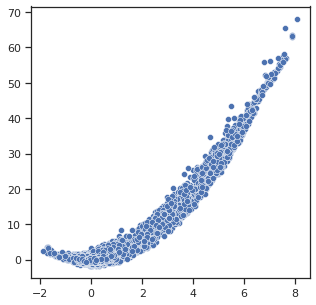

In [58]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=x_array, y=y_array)

In [61]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, y_pred, 'ro')
    plt.show()

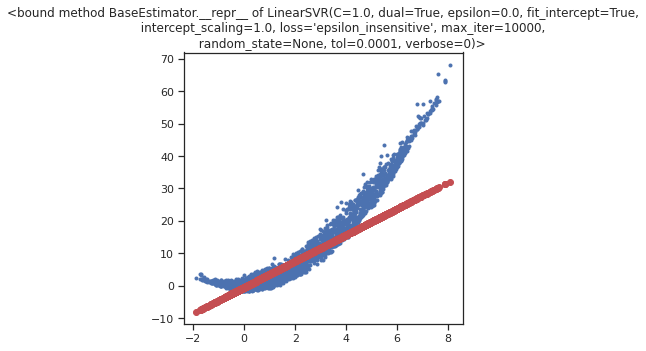

In [62]:
plot_regr(LinearSVR(C=1.0, max_iter=10000))

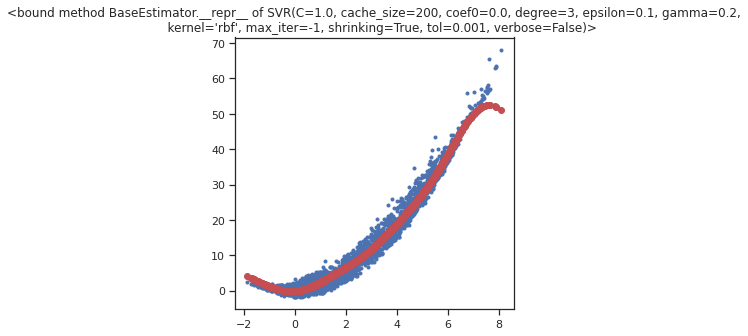

In [63]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

###**Дерево решений**

In [64]:
# Обучим дерево на всех признаках
tree = DecisionTreeRegressor(random_state=1)
tree.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [65]:
# Важность признаков
list(zip(X_train.columns.values, tree.feature_importances_))

[(' Mean of the integrated profile', 0.02764437664705047),
 (' Standard deviation of the integrated profile', 0.029344493324682287),
 (' Excess kurtosis of the integrated profile', 0.7986346670595349),
 (' Skewness of the integrated profile', 0.02697304742290089),
 (' Mean of the DM-SNR curve', 0.020993135609091208),
 (' Standard deviation of the DM-SNR curve', 0.05870193902245078),
 (' Excess kurtosis of the DM-SNR curve', 0.022090683667882426),
 (' Skewness of the DM-SNR curve', 0.015617657246407004)]

In [66]:
sum(tree.feature_importances_)

1.0

In [67]:
def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

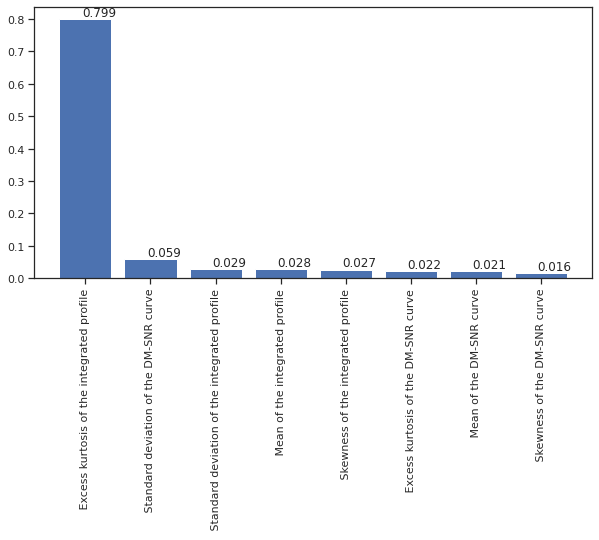

In [68]:
tree_fl, tree_fd = draw_feature_importances(tree, X_train)

In [69]:
# Список признаков, отсортированный на основе важности, и значения важности
tree_fl, tree_fd

([' Excess kurtosis of the integrated profile',
  ' Standard deviation of the DM-SNR curve',
  ' Standard deviation of the integrated profile',
  ' Mean of the integrated profile',
  ' Skewness of the integrated profile',
  ' Excess kurtosis of the DM-SNR curve',
  ' Mean of the DM-SNR curve',
  ' Skewness of the DM-SNR curve'],
 [0.7986346670595349,
  0.05870193902245078,
  0.029344493324682287,
  0.02764437664705047,
  0.02697304742290089,
  0.022090683667882426,
  0.020993135609091208,
  0.015617657246407004])

In [70]:
X_train.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
5744,79.429688,48.745943,1.594305,3.010275,19.621237,52.699148,2.758187,6.734941
12724,26.421875,28.354786,6.414866,45.383641,59.007525,58.278946,1.452548,1.756035
1010,138.476562,58.650843,-0.251328,-0.632375,2.656355,20.022599,8.482193,76.954850
15844,94.117188,41.160247,0.608247,1.171382,2.255853,17.461752,10.027291,112.565713
4163,130.039062,51.597663,-0.033977,-0.202117,17.432274,47.884699,2.799555,7.008160


In [71]:
# Пересортируем признаки на основе важности
X_train_sorted = X_train[tree_fl]
X_train_sorted.head()

,Excess kurtosis of the integrated profile,Standard deviation of the DM-SNR curve,Standard deviation of the integrated profile,Mean of the integrated profile,Skewness of the integrated profile,Excess kurtosis of the DM-SNR curve,Mean of the DM-SNR curve,Skewness of the DM-SNR curve
5744,1.594305,52.699148,48.745943,79.429688,3.010275,2.758187,19.621237,6.734941
12724,6.414866,58.278946,28.354786,26.421875,45.383641,1.452548,59.007525,1.756035
1010,-0.251328,20.022599,58.650843,138.476562,-0.632375,8.482193,2.656355,76.954850
15844,0.608247,17.461752,41.160247,94.117188,1.171382,10.027291,2.255853,112.565713
4163,-0.033977,47.884699,51.597663,130.039062,-0.202117,2.799555,17.432274,7.008160


In [84]:
Y_test_predict = tree.predict(X_test)

In [85]:
mean_absolute_error(Y_test, Y_test_predict)

0.03217877094972067

In [86]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
X_range = list(range(1, len(X_train.columns)+1))
X_range

[1, 2, 3, 4, 5, 6, 7, 8]

In [87]:
mae_list = []
for i in X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    tree_3 = DecisionTreeRegressor(random_state=1).fit(X_train[tree_fl[0:i]], Y_train)
    Y_test_predict_3 = tree_3.predict(X_test[tree_fl[0:i]])
    temp_mae = mean_absolute_error(Y_test, Y_test_predict_3)
    mae_list.append(temp_mae)

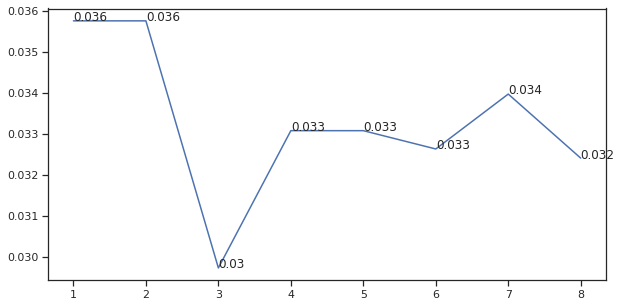

In [88]:
plt.subplots(figsize=(10,5))
plt.plot(X_range, mae_list)
for a,b in zip(X_range, mae_list):
    plt.text(a, b, str(round(b,3)))
plt.show()

###**Оценка качества моделей**

**Линейная модель**

In [89]:
pred = reg1.predict(x_array.reshape(-1, 1))
print("r2_score:", r2_score(y_array, pred))
print("mean_squared_error", mean_squared_error(y_array, pred))

r2_score: 0.8944034470145041
mean_squared_error 4.017001458201285


**SCV**

In [90]:
svr = SVR(kernel='rbf')
svr.fit(X_train, Y_train)
print("r2_score:", r2_score(Y_test, svr.predict(X_test)))
print("mean_squared_error", mean_squared_error(Y_test, svr.predict(X_test)))

r2_score: 0.7018891842122204
mean_squared_error 0.02448353491854104


**Дерево решений**

In [91]:
print("r2_score:", r2_score(Y_test, tree.predict(X_test)))
print("mean_squared_error:", mean_squared_error(Y_test, tree.predict(X_test)))

r2_score: 0.608192211999387
mean_squared_error: 0.03217877094972067


Коэффициент детерминации для всех трех моделей больше 50%, поэтому можно считать, что все три модели являются приемлемыми.